In [1]:
import importlib

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class ModelFactory:
    """
    Model facotry for Keras default models
    """

    def __init__(self):
        self.models_ = dict(
            VGG16=dict(
                input_shape=(224, 224, 3),
                module_name="vgg16",
                last_conv_layer="block5_conv3",
            ),
            VGG19=dict(
                input_shape=(224, 224, 3),
                module_name="vgg19",
                last_conv_layer="block5_conv4",
            ),
            DenseNet121=dict(
                input_shape=(224, 224, 3),
                module_name="densenet",
                last_conv_layer="bn",
            ),
            ResNet50=dict(
                input_shape=(224, 224, 3),
                module_name="resnet50",
                last_conv_layer="activation_49",
            ),
            InceptionV3=dict(
                input_shape=(299, 299, 3),
                module_name="inception_v3",
                last_conv_layer="mixed10",
            ),
            InceptionResNetV2=dict(
                input_shape=(299, 299, 3),
                module_name="inception_resnet_v2",
                last_conv_layer="conv_7b_ac",
            ),
            NASNetMobile=dict(
                input_shape=(224, 224, 3),
                module_name="nasnet",
                last_conv_layer="activation_188",
            ),
            NASNetLarge=dict(
                input_shape=(331, 331, 3),
                module_name="nasnet",
                last_conv_layer="activation_260",
            ),
        )

    def get_last_conv_layer(self, model_name):
        return self.models_[model_name]["last_conv_layer"]

    def get_input_size(self, model_name):
        return self.models_[model_name]["input_shape"][:2]

    def get_model(self, class_names, model_name="DenseNet121", use_base_weights=True,
                  weights_path=None, input_shape=None):

        if use_base_weights is True:
            base_weights = "imagenet"
        else:
            base_weights = None

        base_model_class = getattr(
            importlib.import_module(
                f"tensorflow.keras.applications.{self.models_[model_name]['module_name']}"
            ),
            model_name)

        if input_shape is None:
            input_shape = self.models_[model_name]["input_shape"]

        img_input = Input(shape=input_shape)

        base_model = base_model_class(
            include_top=False,
            input_tensor=img_input,
            input_shape=input_shape,
            weights=base_weights,
            pooling="avg")
        x = base_model.output
        predictions = Dense(len(class_names), activation="sigmoid", name="predictions")(x)
        model = Model(inputs=img_input, outputs=predictions)

        if weights_path == "":
            weights_path = None

        if weights_path is not None:
            print(f"load model weights_path: {weights_path}")
            model.load_weights(weights_path)
        return model

In [3]:
class_names = ["Atelectasis",
"Cardiomegaly",
"Effusion",
"Infiltration",
"Mass",
"Nodule",
"Pneumonia",
"Pneumothorax",
"Consolidation",
"Edema",
"Emphysema",
"Fibrosis",
"Pleural_Thickening",
"Hernia"]

In [4]:
model_factory = ModelFactory()
model = model_factory.get_model(class_names)

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [6]:
model.load_weights("brucechou1983_CheXNet_Keras_0.3.0_weights.h5")

In [7]:
import numpy as np
import os
import pandas as pd
from tensorflow.keras.utils import Sequence
from PIL import Image
from skimage.transform import resize

In [8]:
target_size=(224, 224)

In [9]:
image_path = "D:\\Onedrive\\Machine Learning\\Covid\\NORMAL\\NORMAL (2).png"

#image_path = "D:\\Onedrive\\Machine Learning\\Covid\\Viral Pneumonia\\Viral Pneumonia (2).png"

In [10]:
def open_image(image_path):
    image = Image.open(image_path)
    image_array = np.asarray(image.convert("RGB"))
    image_array = image_array / 255.
    image_array = resize(image_array, target_size)
    return image_array

In [11]:
def transform_batch_images(batch_x):
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])
    batch_x = (batch_x - imagenet_mean) / imagenet_std
    return batch_x

In [12]:
image_array = open_image(image_path)
image_array = transform_batch_images(image_array)
image_array = np.expand_dims(image_array, axis=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


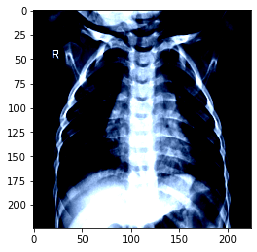

In [13]:
plt.imshow(image_array[0])

In [14]:
model.predict(image_array)

array([[2.4109508e-05, 5.8603766e-10, 1.8079627e-05, 1.2817431e-03,
        1.9135932e-06, 5.4589641e-06, 5.4366973e-09, 1.3279434e-07,
        1.4891592e-06, 4.7565984e-10, 2.3744511e-09, 2.0459368e-09,
        1.7942108e-07, 1.5320928e-17]], dtype=float32)

## Congela os layers e treina apenas o denso final com as imagens novas

In [15]:
for layer in model.layers:
    layer.trainable = False

In [16]:
model.layers[-1].trainable = True

## Troca o layer final

In [17]:
from tensorflow.keras.models import Model

model2 = Model(model.input, model.layers[-2].output)

In [18]:
layer_1 = Dense(120, activation="sigmoid", name="penultimo")(model2.output)

In [19]:
predictions = Dense(3, activation="softmax", name="predictions")(layer_1)

In [20]:
#predictions = Dense(3, activation="sigmoid", name="predictions")(model2.output)

In [21]:
model2 = Model(inputs=model2.inputs, outputs=predictions)

In [22]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

## Treina a dense net final

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [42]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

In [43]:
# load and iterate training dataset
train_it = datagen.flow_from_directory('D:/Covid/Train', class_mode='binary', batch_size=64, save_to_dir = "D:/Covid/Augmented")
# load and iterate validation dataset
val_it = datagen.flow_from_directory('D:/Covid/Valid', class_mode='binary', batch_size=64, save_to_dir = "D:/Covid/Augmented")
# load and iterate test dataset
test_it = datagen.flow_from_directory('D:/Covid/Test', class_mode='binary', batch_size=64)

Found 2180 images belonging to 3 classes.
Found 545 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


In [44]:
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

In [51]:
optimizer = Adam(lr=0.01)
#optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True, name="SGD")

In [52]:
model2.compile(optimizer=optimizer, loss="binary_crossentropy")

In [53]:
# model2.fit(train_it, epochs=150, steps_per_epoch=16, validation_data=val_it, validation_steps=8)

In [54]:
class_weight={0:8, 1:1, 2:1}

In [55]:
model2.fit(train_it, epochs=5, steps_per_epoch=16, validation_data=val_it, validation_steps=8, class_weight=class_weight)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 16 steps, validate for 8 steps
Epoch 1/5
 6/16 [==========>...................] - ETA: 1:09 - loss: 2.9238

KeyboardInterrupt: 

In [39]:
model2.save("TESTE.h5")

In [40]:
a = model2.predict(test_it)

In [41]:
a

array([[0.24852026, 0.35240054, 0.3990792 ],
       [0.207092  , 0.40105897, 0.39184907],
       [0.24120533, 0.38587174, 0.37292287],
       [0.2470522 , 0.3762039 , 0.3767439 ],
       [0.23848937, 0.39835787, 0.36315277],
       [0.24581197, 0.37736672, 0.3768213 ],
       [0.24263863, 0.38028815, 0.37707323],
       [0.24636504, 0.37559068, 0.3780443 ],
       [0.21328308, 0.39994273, 0.38677415],
       [0.24725069, 0.3852    , 0.36754933],
       [0.27998674, 0.38554886, 0.33446437],
       [0.2466591 , 0.3738129 , 0.37952796],
       [0.24806963, 0.37149313, 0.3804372 ],
       [0.24647097, 0.3763934 , 0.37713563],
       [0.24645685, 0.37656167, 0.37698153],
       [0.24589698, 0.37782001, 0.37628302],
       [0.23773204, 0.38737962, 0.37488833],
       [0.2219174 , 0.38338202, 0.39470053],
       [0.24659535, 0.3764608 , 0.3769439 ],
       [0.24695216, 0.37152877, 0.38151902],
       [0.23642553, 0.3895826 , 0.37399185],
       [0.25453052, 0.33211064, 0.4133589 ],
       [0.

In [75]:
model2.evaluate(test_it)

  ...
    to  
  ['...']
3/3 [==============================] - 13s 4s/step - loss: 1.2117


1.2117159366607666

In [79]:
pd.DataFrame(train_it.classes)[0].value_counts()

2    1028
1    1024
0     128
Name: 0, dtype: int64